<a id='the_destination'></a>

# Исследование потребительского поведения

**Описание проекта:**

Есть мобильное приложение стартапа, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи данного мобильного приложения. Для этого представлен датасет с данными по воронке продаж.

Далее необходимо исследовать результаты A/A/B-эксперимента. Дизайнеры предложили поменять шрифты во всём приложении. Менеджеры предполагают, что это достаточно рискованный шаг, так как пользователям новое оформление может показаться непривычным, что впоследствии может привести к падению продаж и оттоку клиентов. Поэтому было принято решение провести A/A/B-тест. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Необходимо выяснить, какой шрифт лучше.

**Цель исследования:**
- Необходимо изучить воронку продаж с помощью A/A/B-эксперимента, чтобы принять решение: менять ли шрифты во всем приложении или нет.

**Задачи:**
- загрузить данные и подготовить их к анализу (привести к нижнему регистру столбцы; изменить тип данных, где необходимо; удалить дубликаты, проверить наличие артефактов)
- детально проанализировать данные (количество событий в логе, среднее кол-во событий на пользователя, проверить данные в динамике)
- проанализировать воронку событий (сколько пользователей доходит до покупки, а сколько - останавливается на предыдущих шагах)
- проанализировать результаты эксперимента (провести А/А тест, проверить гипотезу о равенстве выборок А/В теста, повторно проверить гипотезу, но уже с учетом поправки Бонферрони)
- сделать выводы

<a href='#the_finish'>[Нажмите на эту ссылку, чтобы перейти к выводам исследования]</a>

## Загрузка данных и подготовка их к анализу

In [5]:
# импорт библиотеки pandas
# импорт библиотеки numpy
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots 
from scipy import stats as st
import math as mth

%config InlineBackend.figure_format = 'svg'
pd.set_option('display.max_colwidth', None)

In [6]:
logs = pd.read_csv('C:/Users/snaki/Downloads/logs_exp.csv', sep='\t')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Анализ общей информации о датафреймах

In [7]:
def df_info(df):
    display(df.head(5))
    df.info()
    print('')
    print('Количество дубликатов:', df.duplicated().sum())

In [8]:
df_info(logs)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB

Количество дубликатов: 413


В датафрейме **logs** 4 столбца и 244126 строк:

- **EventName** — название события;
- **DeviceIDHash** — уникальный идентификатор пользователя;
- **EventTimestamp** — время события; - **нужно изменить тип данных на date**
- **ExpId** — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

При первичной проверке было выявлено **413 дубликатов**. Их доля составляет **менее 0,2%** от всей базы данных. Поэтому их можно удалить, так как они не повлияют на общую картину.

### Приведение к нижнему регистру названий столбцов и переименование их

In [9]:
def column_names_lowercase_conversion(df):
    df.columns = df.columns.str.lower()
    
column_names_lowercase_conversion(logs) 
logs.columns = ['event_name', 'device_id', 'event_time_stamp', 'exp_id']
logs.info()
logs.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   event_name        244126 non-null  object
 1   device_id         244126 non-null  int64 
 2   event_time_stamp  244126 non-null  int64 
 3   exp_id            244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,event_name,device_id,event_time_stamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


### Приведение столбца с датами к формату времени

In [10]:
# Переводим дату/время из unix time в timestamp
logs['event_time'] = pd.to_datetime(logs['event_time_stamp'], unit='s')  
# Создаем столбец с датами без учета времени
logs['event_date'] = pd.to_datetime(logs['event_time']).dt.date  

del logs['event_time_stamp']
# Смотрим результат
display(logs.sample(5))
logs.info()

,event_name,device_id,exp_id,event_time,event_date
95720,OffersScreenAppear,1434659102910304056,248,2019-08-03 14:37:54,2019-08-03
106203,OffersScreenAppear,2438520924615884865,246,2019-08-03 19:52:53,2019-08-03
34124,MainScreenAppear,294355503360609826,246,2019-08-01 18:33:10,2019-08-01
120542,PaymentScreenSuccessful,6220847999332178356,246,2019-08-04 11:12:26,2019-08-04
108845,MainScreenAppear,4086924768271071570,247,2019-08-04 03:33:25,2019-08-04


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   device_id   244126 non-null  int64         
 2   exp_id      244126 non-null  int64         
 3   event_time  244126 non-null  datetime64[ns]
 4   event_date  244126 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.3+ MB


### Удаление дубликатов

In [11]:
logs = logs.drop_duplicates().reset_index(drop=True)
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   device_id   243713 non-null  int64         
 2   exp_id      243713 non-null  int64         
 3   event_time  243713 non-null  datetime64[ns]
 4   event_date  243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 9.3+ MB


После удаления дубликатов датафрейм содержит **243713 строк.**

### Проверка артефактов

In [12]:
print(logs['event_name'].unique())

['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']


In [13]:
print(logs['exp_id'].unique())

[246 248 247]


**В датафрейме нет артефактов.**

## Часть. Детальный анализ данных

### Сколько всего событий в логе?

В предыдущем блоке (проверка артефактов) мы увидели, что в логе присутствуют **5 событий:**
- **MainScreenAppear** - переход на главную (первую) страницу приложения
- **PaymentScreenSuccessful** - переход на страницу "оплата прошла успешно" 
- **CartScreenAppear** - переход на страницу "корзина"
- **OffersScreenAppear** - переход на страницу "предложения"
- **Tutorial** - переход на страницу "руководство"

### Сколько в среднем событий приходится на пользователя?

In [14]:
#Сгруппируем датафрейм по пользователям
average_number_of_events_per_user = logs.groupby('device_id')['event_name'].count().reset_index()
average_number_of_events_per_user.columns = ['device_id', 'event_number']
display(average_number_of_events_per_user.head(5).sort_values(by='event_number', ascending=False))

#Вычислим среднее количество событий на одного пользователя
print(
    'Среднее количество событий на одного пользователя составляет:', round(average_number_of_events_per_user['event_number'].mean(), 0)
)

,device_id,event_number
4,7702139951469979,137
2,6922444491712477,47
3,7435777799948366,6
1,6909561520679493,5
0,6888746892508752,1


Среднее количество событий на одного пользователя составляет: 32.0


In [15]:
#number_of_events_per_user = logs.groupby('device_id')['event_name'].count().reset_index()
number_of_events_per_user = (
    logs
    .groupby('device_id')['event_name']
    .count()
    .reset_index()
    .rename(columns={'event_name': 'event_number'})
    .sort_values(by='event_number', ascending=False)
)
number_of_events_per_user.head(5)

,device_id,event_number
5116,6304868067479728361,2307
147,197027893265565660,1998
3714,4623191541214045580,1768
5590,6932517045703054087,1439
1391,1754140665440434215,1221


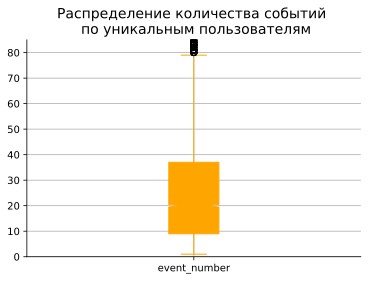

In [16]:
#построим "ящик с усами"; обрежем диаграмму размаха до 85 (таким образом, увеличим масштаб диаграммы)
bplot = number_of_events_per_user.boxplot('event_number',
            notch=True,
            vert=True,
            patch_artist=True,
            color='orange')
plt.ylim(0, 85)
plt.title('Распределение количества событий \n по уникальным пользователям', fontsize=14)
sns.despine()

По ящику с усами мы видим, что медиана распределения количества событий находится **на уровне 20 шт. Выше 79 шт. - это выбросы. Максимальное кол-во событий** на одного уникального пользователя составляет **2307 шт.** Данное количество нереально для обычного физического лица. Тут возможен один из вариантов:
- это либо оптовый покупатель,
- либо техническая ошибка, и с ней необходимо обратиться в техподдержку.

### Проверка данных в разрезе периода

In [17]:
#определяем минимальную и максимальную дату
min_analysis_date = logs['event_date'].min()
observation_date = logs['event_date'].max()

print('Минимальная и максимальная даты датафрейма:',min_analysis_date, 'и', observation_date)

Минимальная и максимальная даты датафрейма: 2019-07-25 и 2019-08-07


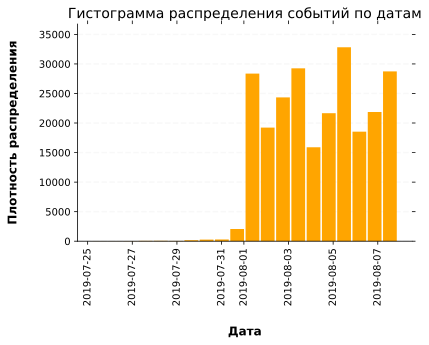

In [18]:
#построим гистограмму по дате
ax = logs.hist('event_time', bins=20, grid=False, figsize=(6, 4), color='orange', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Дата", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Плотность распределения", labelpad=20, weight='bold', size=12)
    plt.title('Гистограмма распределения событий по датам', fontsize=14)
    plt.xticks(rotation='vertical')
sns.despine()
plt.show()    

**БОльшая часть данных приходится на период с 01.08.2019.** Но и до этого периода были какие-то события, посмотрим на них в таблице и на графике распределения и решим удалять их или нет.

In [19]:
#Срежем датафрейм с первого дня теста по 01.08.2019
check_logs_by_data = logs[logs['event_time'] < '2019-08-01']

print('Количество событий в общем датафрейме (до удаления):', logs['device_id'].count())
print('Количество событий, которые "доезжают" из прошлого:', check_logs_by_data['event_name'].count())
print('Доля событий, которые будут удалены, относительно всего датафрейма, %:', round((check_logs_by_data['event_name'].count() / logs['device_id'].count() * 100), 2))
print('Количество уникальных пользователей в общем датафрейме (до удаления):', logs['device_id'].nunique())
print('Количество уникальных пользователей, которые "доезжают" из прошлого и мы их удалим:', check_logs_by_data['device_id'].nunique())

Количество событий в общем датафрейме (до удаления): 243713
Количество событий, которые "доезжают" из прошлого: 2826
Доля событий, которые будут удалены, относительно всего датафрейма, %: 1.16
Количество уникальных пользователей в общем датафрейме (до удаления): 7551
Количество уникальных пользователей, которые "доезжают" из прошлого и мы их удалим: 1451


In [20]:
#Рассмотрим временной период с 31.07 по 01.08 в часовом таймфрейме
data_slice_by_date = logs[(logs['event_time'] >= '2019-07-31') & (logs['event_time'] <= '2019-08-02')]

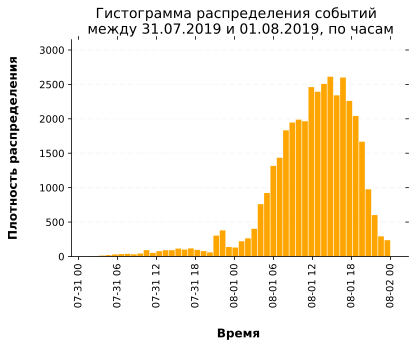

In [21]:
#построим гистограмму
ax = data_slice_by_date.hist('event_time', bins=48, grid=False, figsize=(6, 4), color='orange', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Время", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Плотность распределения", labelpad=20, weight='bold', size=12)
    plt.title('Гистограмма распределения событий \n между 31.07.2019 и 01.08.2019, по часам', fontsize=14)
    plt.xticks(rotation='vertical')
sns.despine()
plt.show()    

Рассмотрев детально данные за период с 31.07.2019 по 01.08.2019, мы видим, что **тест начался в 9 вечера 31.07.2019.** Мы удалим эти события, так как они составляют **чуть более 1%** от всего датафрейма. Это не повлияет на общую картину.

In [22]:
#Удалим "доезжающие" события
logs_result = logs[logs['event_time'] >= '2019-08-01']

print('Количество событий в общем датафрейме (до удаления):', logs['device_id'].count())
print('Количество событий, которые остались:', logs_result['event_name'].count())
print('Доля событий, которые остались, относительно всего датафрейма, %:', round((logs_result['event_name'].count() / logs['device_id'].count() * 100), 2))
print('Количество уникальных пользователей в общем датафрейме (до удаления):', logs['device_id'].nunique())
print('Количество уникальных пользователей, которые остались после удаления:', logs_result['device_id'].nunique())
print('Доля уникальных пользователей, которые остались, относительно всего датафрейма, %:', round((logs_result['device_id'].nunique() / logs['device_id'].nunique() * 100), 2))

Количество событий в общем датафрейме (до удаления): 243713
Количество событий, которые остались: 240887
Доля событий, которые остались, относительно всего датафрейма, %: 98.84
Количество уникальных пользователей в общем датафрейме (до удаления): 7551
Количество уникальных пользователей, которые остались после удаления: 7534
Доля уникальных пользователей, которые остались, относительно всего датафрейма, %: 99.77


В результате удаления, из датафрейма исчезли **1,2% событий и менее 0,3% пользователей**. Последние, видимо, вернулись в приложение в более поздний период. В целом, очистка датафрейма не повлияла на общую картину данных. Единственно, необходимо проверить все ли экспериментальные группы остались после очистки датафрейма.

In [23]:
print(logs_result['exp_id'].unique())

[246 247 248]


Да, все. Отлично

## Часть. Анализ воронки событий

In [24]:
#Посмотрим, как часто происходили те или иные события в приложении
events_frequency = logs_result.groupby('event_name')['device_id'].count().sort_values(ascending=False).reset_index()
events_frequency.columns = ['event_name', 'number']

display(events_frequency)

,event_name,number
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


In [71]:
# Строим график воронки
fig = go.Figure(go.Funnel(
        name = 'test',
        y = events_frequency['event_name'],
        x = events_frequency['number'],
        textposition = "inside",
        textinfo = "value+percent previous+percent initial"))
fig.update_layout(
    title={
        'text': 'Воронка по событиям, совершенным всеми пользователями',
        'y':0.88,
        'x':0.53,
        'xanchor': 'center',
        'yanchor': 'top'},
    )
fig.show()

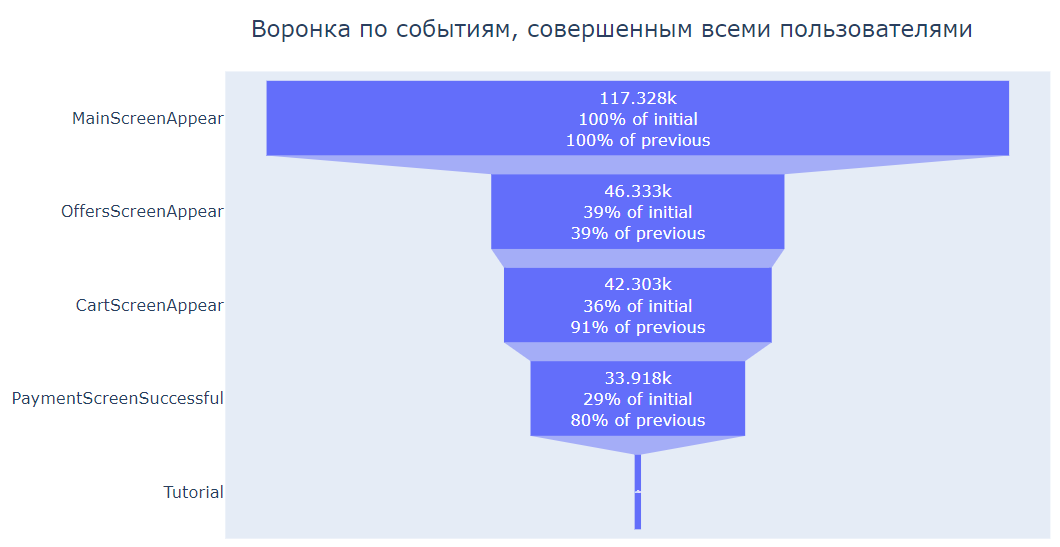

**Самое частое событие в приложении - это переход на главную его страницу.** **За неделю** на главную страницу пришло более **117 тысяч пользователей.** Следующим по популярности событием является **переход на страницу с предложениями** (т.е. товарами): из 117 тыс человек на эту страницу приходит только **39% (чуть более 46 тыс человек).** Видимо, **есть какая-то значимая причина,** по которой **более 60% посетителей "отваливается"** на главной странице. Нужно ее выявить.

**Со страницы с товарами в корзину переходит 91% пользователей; а на страницу с оплатой приходит 80% пользователей с предыдущей страницы.** Это прекрасная конверсия!

**Именно в таком порядке платящий пользователь работает с приложением.**

**Страница Tutorial** (инструкция) совершенно не пользуется популярностью у пользователей (менее 1% от всех посетителей ее изучает).

In [26]:
#Посмотрим, сколько пользователей совершали каждое из этих событий
users_number_committed_each_of_the_events = logs_result.groupby(['device_id', 'event_name'])['event_date'].nunique().reset_index()

users_number_committed_each_of_the_events_result = users_number_committed_each_of_the_events.groupby('device_id')['event_name'].count().reset_index()
users_number_committed_each_of_the_events_result_1 = users_number_committed_each_of_the_events_result.loc[users_number_committed_each_of_the_events_result['event_name'] == 5]
print('Количество пользователей, которые совершали каждое из событий:', users_number_committed_each_of_the_events_result_1['device_id'].count())


Количество пользователей, которые совершали каждое из событий: 466


In [27]:
#Отсортируем события по числу пользователей и посчитаем долю пользователей, которые хоть раз совершали событие
sort_events_by_number_of_users = logs_result.groupby('event_name')['device_id'].nunique().reset_index()
sort_events_by_number_of_users.columns = ['event_name', 'number_of_users']
sort_events_by_number_of_users = sort_events_by_number_of_users.sort_values(by='number_of_users', ascending=False)

sum_users_number = sort_events_by_number_of_users['number_of_users'].sum()
sort_events_by_number_of_users['ratio, %'] = round((sort_events_by_number_of_users['number_of_users'] / sum_users_number * 100), 2)

display(sort_events_by_number_of_users)

,event_name,number_of_users,"ratio, %"
1,MainScreenAppear,7419,36.86
2,OffersScreenAppear,4593,22.82
0,CartScreenAppear,3734,18.55
3,PaymentScreenSuccessful,3539,17.59
4,Tutorial,840,4.17


**При рассмотрении воронки в разрезе уникальных пользователей,** мы можем отметить, что порядок работы пользователей с приложением остается прежним. **Чаще всего** потребители заходят **на главную страницу (37%),** далее они отправляются **на страницу с товарами (23%),** после этого переходят **в корзину (19%), оплачивают товары 18% от всех пользователей.**
Из воронки необходимо **убрать этап "Tutorial"** - это дополнительная страница, не участвующая в воронке продаж, и многие пользователи ее не посещают. Что, собственно, и показывает предыдущий датафрейм **(только 4% от всех уникальных пользователей заходят на данную страницу).**

In [28]:
# Отбираем все записи без событий Tutorial с группировкой по event_name
all_exp = (logs_result.loc[logs_result['event_name'] != 'Tutorial']
             .groupby(['event_name']) # Группируем по ивенту
             .agg(count_events = ('device_id', 'nunique'))
             .reset_index()
             .sort_values('count_events', ascending=False) # по убыванию кол-ва событий           
             )

# Строим график воронки
fig = go.Figure(go.Funnel(
        name = 'test',
        y = all_exp['event_name'],
        x = all_exp['count_events'],
        textposition = "inside",
        textinfo = "value+percent previous+percent initial"))
fig.update_layout(
    title={
        'text': 'Воронка по событиям, совершенных уникальными пользователями',
        'y':0.88,
        'x':0.53,
        'xanchor': 'center',
        'yanchor': 'top'},
    )
fig.show()

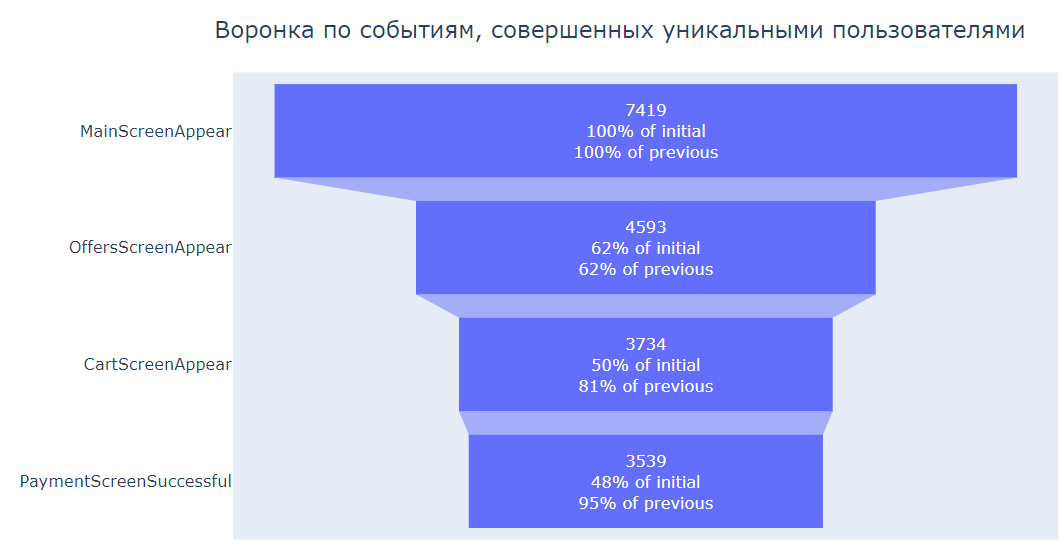

По полученной воронке событий, мы видим, что **наибольшую потерю пользователей** мы получаем на этапе перехода с главной страницы на страницу с предложениями **(38% пользователей)**. **Меньше всего пользователей мы теряем на последнем этапе:** при переходе из корзины на страницу оплаты **(5%).** В итоге, **с первого события до оплаты доходит 48% пользователей.**

## Часть. Анализ результатов эксперимента

### Предварительная проверка полученных данных A/B теста (A/A тест)

**Критерии успешного A/A-теста:**
-	Количество пользователей в различных группах различается не более, чем на 1%;
-	Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
-	Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
-	Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.


#### Проверка количества пользователей в различных группах

In [29]:
#Посмотрим, сколько пользователей в каждой экспериментальной группе
users_number_in_each_experimental_group = logs_result.groupby('exp_id')['device_id'].nunique().reset_index()
users_number_in_each_experimental_group.columns = ['exp_id', 'users_number']
display(users_number_in_each_experimental_group)

groups_comparison_a1_a2 = users_number_in_each_experimental_group['users_number'].iloc[1] / users_number_in_each_experimental_group['users_number'].iloc[0] - 1
groups_comparison_a1_b = users_number_in_each_experimental_group['users_number'].iloc[2] / users_number_in_each_experimental_group['users_number'].iloc[0] - 1
groups_comparison_a2_b = users_number_in_each_experimental_group['users_number'].iloc[2] / users_number_in_each_experimental_group['users_number'].iloc[1] - 1

print('Кол-во пользователей в группе A2 больше кол-ва пользователей группы A1 на:', f'{groups_comparison_a1_a2:.0%}')
print('Кол-во пользователей в группе B больше кол-ва пользователей группы A1 на:', f'{groups_comparison_a1_b:.0%}')
print('Кол-во пользователей в группе B больше кол-ва пользователей группы A2 на:', f'{groups_comparison_a2_b:.0%}')

,exp_id,users_number
0,246,2484
1,247,2513
2,248,2537


Кол-во пользователей в группе A2 больше кол-ва пользователей группы A1 на: 1%
Кол-во пользователей в группе B больше кол-ва пользователей группы A1 на: 2%
Кол-во пользователей в группе B больше кол-ва пользователей группы A2 на: 1%


#### Проверка "деления" трафика

In [30]:
#Проверим количество повторяющихся пользователей в группах
both_users = logs_result.groupby('device_id')['exp_id'].nunique().reset_index().query('exp_id > 1')
both_users['flag'] = 1
print('Количество повторяющихся пользователей в группах A и B равно:', both_users['flag'].count())

Количество повторяющихся пользователей в группах A и B равно: 0


В процессе предварительной проверки было выявлено следующее:
- **Количество пользователей в группах a1, a2 и b** различается не более, чем на **2%.** Вообще должно быть не более 1%, но 2% - это не критичная разница.
- **Количество повторяющихся пользователей в группах a1, a2 и b равно 0.**

Это значит, что тест был проведен качественно и на его результаты можно смело полагаться.

### Проверка гипотезы о равенстве пропорций выборок 246 и 247 (a1 и a2)

Проверим гипотезу о равенстве пропорций выборок а1 и а2

**Нулевая гипотеза:** различий в пропорциях выборок а1 и а2 нет

**Альтернативная гипотеза:** различия в пропорциях выборок а1 и а2 есть

In [31]:
#Проверим гипотезу о равенстве пропорций выборок
def test_the_hypothesis_about_the_equality_of_sample_proportions(group_1, group_2, event_name, alpha):

    alpha = alpha # критический уровень статистической значимости

    successes = np.array([group_1[group_1['event_name'] == event_name]['device_id'].nunique(), 
                        group_2[group_2['event_name'] == event_name]['device_id'].nunique()])
 
    trials = np.array([group_1['device_id'].nunique(), 
                    group_2['device_id'].nunique()])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 
    

In [32]:
cross_section_of_the_dataframe_by_group_a1 = logs_result.query('exp_id == 246')
cross_section_of_the_dataframe_by_group_a2 = logs_result.query('exp_id == 247')
cross_section_of_the_dataframe_by_group_b = logs_result.query('exp_id == 248')

In [33]:
test_the_hypothesis_about_the_equality_of_sample_proportions(
    cross_section_of_the_dataframe_by_group_a1, cross_section_of_the_dataframe_by_group_a2, 'PaymentScreenSuccessful', 0.05
)

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Нулевую гипотезу о различии в пропорциях выборок мы не можем отвергнуть. Это значит, **что мы можем их считать равными, а это позволяет нам перейти к А/В-тесту и быть уверенными в полученном результате теста.**

#### Проверка отличий между группами по каждому событию на вопрос статистической достоверности

In [34]:
#Посчитаем число пользователей, совершивших каждое событие в каждой из контрольных групп
#А также посчитаем долю пользователей, совершивших это событие
logs_result_without_tutorial = logs_result.query('event_name != "Tutorial"')
table_test = logs_result_without_tutorial.pivot_table(
    index='event_name', 
    columns='exp_id',
    values='device_id',
    aggfunc='nunique'
).sort_values(246, ascending=False).reset_index()
table_test

exp_id,event_name,246,247,248
0,MainScreenAppear,2450,2476,2493
1,OffersScreenAppear,1542,1520,1531
2,CartScreenAppear,1266,1238,1230
3,PaymentScreenSuccessful,1200,1158,1181


In [35]:
#Посчитаем число пользователей, совершивших каждое событие в каждой из контрольных групп
#А также посчитаем долю пользователей, совершивших это событие
logs_result_without_tutorial = logs_result.query('event_name != "Tutorial"')
table_test = logs_result_without_tutorial.pivot_table(
    index='event_name', 
    columns='exp_id',
    values='device_id',
    aggfunc='nunique'
).sort_values(246, ascending=False).reset_index()
table_test.columns = ['event','a1','a2','b']
table_test['a'] = table_test['a1']+table_test['a2']

table_test['sum'] = table_test.sum(axis=1)
table_test['ratio_a1, %'] = round((table_test['a1'] / table_test['sum'] * 100), 2)
table_test['ratio_a2, %'] = round((table_test['a2'] / table_test['sum'] * 100), 2)
table_test['ratio_b, %'] = round((table_test['b'] / table_test['sum'] * 100), 2)
table_test['ratio_a, %'] = round((table_test['a'] / table_test['sum'] * 100), 2)
table_test

C:\Users\snaki\AppData\Local\Temp\ipykernel_24672\3822367128.py:13: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



,event,a1,a2,b,a,sum,"ratio_a1, %","ratio_a2, %","ratio_b, %","ratio_a, %"
0,MainScreenAppear,2450,2476,2493,4926,12345,19.85,20.06,20.19,39.90
1,OffersScreenAppear,1542,1520,1531,3062,7655,20.14,19.86,20.00,40.00
2,CartScreenAppear,1266,1238,1230,2504,6238,20.29,19.85,19.72,40.14
3,PaymentScreenSuccessful,1200,1158,1181,2358,5897,20.35,19.64,20.03,39.99


На первый взгляд, можно сделать предварительный вывод по полученной таблице, что **контрольные группы на каждом отдельном событии +- равны (их доли составляют в среднем 33%), что означает, что изменение шрифта не повлияло на желание пользователей взаимодействовать с приложением.** Но нужно проверить это через z-test.

#### Проверка гипотезы о равенстве пропорций по событию MainScreenAppear

Проверим гипотезы о равенстве пропорций выборок **а1 и а2 / a1 и b / a2 и b** по событию MainScreenAppear

**Нулевая гипотеза:** различий в пропорциях выборок **а1 и а2 / a1 и b / a2 и b** по событию MainScreenAppear нет

**Альтернативная гипотеза:** различия в пропорциях выборок **а1 и а2 / a1 и b / a2 и b** по событию MainScreenAppear есть

In [36]:
#Проверим гипотезу о равенстве пропорций выборок a1 и a2 по событию MainScreenAppear
test_the_hypothesis_about_the_equality_of_sample_proportions(
    cross_section_of_the_dataframe_by_group_a1, cross_section_of_the_dataframe_by_group_a2, 'MainScreenAppear', 0.05
)

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Пропорции выборок **при изучении события MainScreenAppear можно считать одинаковыми** в обеих контрольных группах.

In [37]:
#Проверим гипотезу о равенстве пропорций выборок a1 и b по событию MainScreenAppear
test_the_hypothesis_about_the_equality_of_sample_proportions(
    cross_section_of_the_dataframe_by_group_a1, cross_section_of_the_dataframe_by_group_b, 'MainScreenAppear', 0.05
)

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Пропорции выборок **при изучении события MainScreenAppear можно считать одинаковыми** в обеих контрольных группах.

In [38]:
#Проверим гипотезу о равенстве пропорций выборок a2 и b по событию MainScreenAppear
test_the_hypothesis_about_the_equality_of_sample_proportions(
    cross_section_of_the_dataframe_by_group_a2, cross_section_of_the_dataframe_by_group_b, 'MainScreenAppear', 0.05
)

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Пропорции выборок **при изучении события MainScreenAppear можно считать одинаковыми** в обеих контрольных группах.

**В результате z-test по событию MainScreenAppear мы выяснили, что изменение шрифта никак не повлияло на желание пользователей взаимодействовать с приложением.**

#### Проверка гипотезы о равенстве пропорций по событию OffersScreenAppear

Проверим гипотезы о равенстве пропорций выборок **а1 и а2 / a1 и b / a2 и b** по событию OffersScreenAppear

**Нулевая гипотеза:** различий в пропорциях выборок **а1 и а2 / a1 и b / a2 и b** по событию OffersScreenAppear нет

**Альтернативная гипотеза:** различия в пропорциях выборок **а1 и а2 / a1 и b / a2 и b** по событию OffersScreenAppear есть

In [39]:
#Проверим гипотезу о равенстве пропорций выборок a1 и a2 по событию OffersScreenAppear
test_the_hypothesis_about_the_equality_of_sample_proportions(
    cross_section_of_the_dataframe_by_group_a1, cross_section_of_the_dataframe_by_group_a2, 'OffersScreenAppear', 0.05
)

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Пропорции выборок **при изучении события OffersScreenAppear можно считать одинаковыми** в обеих контрольных группах.

In [40]:
#Проверим гипотезу о равенстве пропорций выборок a1 и b по событию OffersScreenAppear
test_the_hypothesis_about_the_equality_of_sample_proportions(
    cross_section_of_the_dataframe_by_group_a1, cross_section_of_the_dataframe_by_group_b, 'OffersScreenAppear', 0.05
)

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Пропорции выборок **при изучении события OffersScreenAppear можно считать одинаковыми** в обеих контрольных группах.

In [41]:
#Проверим гипотезу о равенстве пропорций выборок a2 и b по событию OffersScreenAppear
test_the_hypothesis_about_the_equality_of_sample_proportions(
    cross_section_of_the_dataframe_by_group_a2, cross_section_of_the_dataframe_by_group_b, 'OffersScreenAppear', 0.05
)

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Пропорции выборок **при изучении события OffersScreenAppear можно считать одинаковыми** в обеих контрольных группах.

**В результате z-test по событию OffersScreenAppear мы выяснили, что изменение шрифта никак не повлияло на желание пользователей взаимодействовать с приложением.**

#### Проверка гипотезы о равенстве пропорций по событию CartScreenAppear

Проверим гипотезы о равенстве пропорций выборок **а1 и а2 / a1 и b / a2 и b** по событию CartScreenAppear

**Нулевая гипотеза:** различий в пропорциях выборок **а1 и а2 / a1 и b / a2 и b** по событию CartScreenAppear нет

**Альтернативная гипотеза:** различия в пропорциях выборок **а1 и а2 / a1 и b / a2 и b** по событию CartScreenAppear есть

In [42]:
#Проверим гипотезу о равенстве пропорций выборок a1 и a2 по событию CartScreenAppear
test_the_hypothesis_about_the_equality_of_sample_proportions(
    cross_section_of_the_dataframe_by_group_a1, cross_section_of_the_dataframe_by_group_a2, 'CartScreenAppear', 0.05
)

p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Пропорции выборок **при изучении события CartScreenAppear можно считать одинаковыми** в обеих контрольных группах.

In [43]:
#Проверим гипотезу о равенстве пропорций выборок a1 и b по событию CartScreenAppear
test_the_hypothesis_about_the_equality_of_sample_proportions(
    cross_section_of_the_dataframe_by_group_a1, cross_section_of_the_dataframe_by_group_b, 'CartScreenAppear', 0.05
)

p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Пропорции выборок **при изучении события CartScreenAppear можно считать одинаковыми** в обеих контрольных группах.

In [44]:
#Проверим гипотезу о равенстве пропорций выборок a2 и b по событию CartScreenAppear
test_the_hypothesis_about_the_equality_of_sample_proportions(
    cross_section_of_the_dataframe_by_group_a2, cross_section_of_the_dataframe_by_group_b, 'CartScreenAppear', 0.05
)

p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Пропорции выборок **при изучении события CartScreenAppear можно считать одинаковыми** в обеих контрольных группах.

**В результате z-test по событию CartScreenAppear мы выяснили, что изменение шрифта никак не повлияло на желание пользователей взаимодействовать с приложением.**

#### Проверка гипотезы о равенстве пропорций по событию PaymentScreenSuccessful

Проверим гипотезы о равенстве пропорций выборок **а1 и а2 / a1 и b / a2 и b** по событию PaymentScreenSuccessful

**Нулевая гипотеза:** различий в пропорциях выборок **а1 и а2 / a1 и b / a2 и b** по событию PaymentScreenSuccessful нет

**Альтернативная гипотеза:** различия в пропорциях выборок **а1 и а2 / a1 и b / a2 и b** по событию PaymentScreenSuccessful есть

In [45]:
#Проверим гипотезу о равенстве пропорций выборок a1 и a2 по событию PaymentScreenSuccessful
test_the_hypothesis_about_the_equality_of_sample_proportions(
    cross_section_of_the_dataframe_by_group_a1, cross_section_of_the_dataframe_by_group_a2, 'PaymentScreenSuccessful', 0.05
)

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Пропорции выборок **при изучении события PaymentScreenSuccessful можно считать одинаковыми** в обеих контрольных группах.

In [46]:
#Проверим гипотезу о равенстве пропорций выборок a1 и b по событию PaymentScreenSuccessful
test_the_hypothesis_about_the_equality_of_sample_proportions(
    cross_section_of_the_dataframe_by_group_a1, cross_section_of_the_dataframe_by_group_b, 'PaymentScreenSuccessful', 0.05
)

p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Пропорции выборок **при изучении события PaymentScreenSuccessful можно считать одинаковыми** в обеих контрольных группах.

In [47]:
#Проверим гипотезу о равенстве пропорций выборок a2 и b по событию PaymentScreenSuccessful
test_the_hypothesis_about_the_equality_of_sample_proportions(
    cross_section_of_the_dataframe_by_group_a2, cross_section_of_the_dataframe_by_group_b, 'PaymentScreenSuccessful', 0.05
)

p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Пропорции выборок **при изучении события PaymentScreenSuccessful можно считать одинаковыми** в обеих контрольных группах.

**В результате z-test по событию PaymentScreenSuccessful мы выяснили, что изменение шрифта никак не повлияло на желание пользователей взаимодействовать с приложением.**

### Проверка гипотезы о равенстве пропорций объединенной контрольной группы с группой с измененным шрифтом по разным событиям

In [48]:
#Объединим контрольные группы а1 и а2 в а
cross_section_of_the_dataframe_by_group_a = logs_result.query('exp_id == 246 | exp_id == 247')
display(cross_section_of_the_dataframe_by_group_a.head(5))

,event_name,device_id,exp_id,event_time,event_date
2826,Tutorial,3737462046622621720,246,2019-08-01 00:07:28,2019-08-01
2827,MainScreenAppear,3737462046622621720,246,2019-08-01 00:08:00,2019-08-01
2828,MainScreenAppear,3737462046622621720,246,2019-08-01 00:08:55,2019-08-01
2829,OffersScreenAppear,3737462046622621720,246,2019-08-01 00:08:58,2019-08-01
2830,MainScreenAppear,1433840883824088890,247,2019-08-01 00:08:59,2019-08-01


In [49]:
cross_section_of_the_dataframe_by_group_a_check = cross_section_of_the_dataframe_by_group_a.groupby('exp_id')['device_id'].nunique().reset_index()
display(cross_section_of_the_dataframe_by_group_a_check)

,exp_id,device_id
0,246,2484
1,247,2513


Проверим гипотезы о равенстве пропорций выборок **а и b** по событию MainScreenAppear

**Нулевая гипотеза:** различий в пропорциях выборок **а и b** по событию MainScreenAppear нет

**Альтернативная гипотеза:** различия в пропорциях выборок **а и b** по событию MainScreenAppear есть

In [50]:
#Проверим гипотезу о равенстве пропорций выборок а и b по событию MainScreenAppear
test_the_hypothesis_about_the_equality_of_sample_proportions(
    cross_section_of_the_dataframe_by_group_a, cross_section_of_the_dataframe_by_group_b, 'MainScreenAppear', 0.05
)

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Пропорции выборок **при изучении события MainScreenAppear можно считать одинаковыми** в обеих контрольных группах.

Проверим гипотезы о равенстве пропорций выборок **а и b** по событию OffersScreenAppear

**Нулевая гипотеза:** различий в пропорциях выборок **а и b** по событию OffersScreenAppear нет

**Альтернативная гипотеза:** различия в пропорциях выборок **а и b** по событию OffersScreenAppear есть

In [51]:
#Проверим гипотезу о равенстве пропорций выборок а и b по событию OffersScreenAppear
test_the_hypothesis_about_the_equality_of_sample_proportions(
    cross_section_of_the_dataframe_by_group_a, cross_section_of_the_dataframe_by_group_b, 'OffersScreenAppear', 0.05
)

p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Пропорции выборок **при изучении события OffersScreenAppear можно считать одинаковыми** в обеих контрольных группах.

Проверим гипотезы о равенстве пропорций выборок **а и b** по событию CartScreenAppear

**Нулевая гипотеза:** различий в пропорциях выборок **а и b** по событию CartScreenAppear нет

**Альтернативная гипотеза:** различия в пропорциях выборок **а и b** по событию CartScreenAppear есть

In [52]:
#Проверим гипотезу о равенстве пропорций выборок а и b по событию CartScreenAppear
test_the_hypothesis_about_the_equality_of_sample_proportions(
    cross_section_of_the_dataframe_by_group_a, cross_section_of_the_dataframe_by_group_b, 'CartScreenAppear', 0.05
)

p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Пропорции выборок **при изучении события CartScreenAppear можно считать одинаковыми** в обеих контрольных группах.

Проверим гипотезу о равенстве пропорций выборок а и b по событию PaymentScreenSuccessful

**Нулевая гипотеза:** различий в пропорциях выборок а и b по событию PaymentScreenSuccessful нет

**Альтернативная гипотеза:** различия в пропорциях выборок а и b по событию PaymentScreenSuccessful есть

In [53]:
test_the_hypothesis_about_the_equality_of_sample_proportions(
    cross_section_of_the_dataframe_by_group_a, cross_section_of_the_dataframe_by_group_b, 'PaymentScreenSuccessful', 0.05
)

p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Пропорции выборок **при изучении события PaymentScreenSuccessful можно считать одинаковыми** в обеих контрольных группах. 

Данный анализ показывает, что **изменение шрифта и в данном случае не влияет на восприятие пользователей интерфейса сайта.**

### Поправка Бонферрони. Проверка гипотезы о равенстве пропорций выборок 246 и 247 (a1 и a2)

**Пересчитаем наши гипотезы с уровнем значимости, посчитанном с учетом поправки Бонферрони.**

In [54]:
bonferroni_alpha = 0.05 / 3  

#### Поправка Бонферрони. Проверка гипотезы о равенстве пропорций по событию MainScreenAppear

Проверим гипотезы о равенстве пропорций выборок **а1 и а2 / a1 и b / a2 и b** по событию MainScreenAppear с учетом поправки Бонферрони

**Нулевая гипотеза:** различий в пропорциях выборок **а1 и а2 / a1 и b / a2 и b** по событию MainScreenAppear нет

**Альтернативная гипотеза:** различия в пропорциях выборок **а1 и а2 / a1 и b / a2 и b** по событию MainScreenAppear есть

In [55]:
#Проверим гипотезу о равенстве пропорций выборок a1 и a2 по событию MainScreenAppear
test_the_hypothesis_about_the_equality_of_sample_proportions(
    cross_section_of_the_dataframe_by_group_a1, cross_section_of_the_dataframe_by_group_a2, 'MainScreenAppear', bonferroni_alpha
)

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [56]:
#Проверим гипотезу о равенстве пропорций выборок a1 и b по событию MainScreenAppear
test_the_hypothesis_about_the_equality_of_sample_proportions(
    cross_section_of_the_dataframe_by_group_a1, cross_section_of_the_dataframe_by_group_b, 'MainScreenAppear', bonferroni_alpha
)

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [57]:
#Проверим гипотезу о равенстве пропорций выборок a2 и b по событию MainScreenAppear
test_the_hypothesis_about_the_equality_of_sample_proportions(
    cross_section_of_the_dataframe_by_group_a2, cross_section_of_the_dataframe_by_group_b, 'MainScreenAppear', bonferroni_alpha
)

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Пропорции выборок **при изучении события MainScreenAppear можно считать одинаковыми** во всех рассматриваемых контрольных группах.

**В результате z-test по событию MainScreenAppear с учетом поправки Бонферрони мы выяснили, что изменение шрифта никак не повлияло на желание пользователей взаимодействовать с приложением.**

#### Поправка Бонферрони. Проверка гипотезы о равенстве пропорций по событию OffersScreenAppear

Проверим гипотезы о равенстве пропорций выборок **а1 и а2 / a1 и b / a2 и b** по событию OffersScreenAppear с учетом поправки Бонферрони

**Нулевая гипотеза:** различий в пропорциях выборок **а1 и а2 / a1 и b / a2 и b** по событию OffersScreenAppear нет

**Альтернативная гипотеза:** различия в пропорциях выборок **а1 и а2 / a1 и b / a2 и b** по событию OffersScreenAppear есть

In [58]:
#Проверим гипотезу о равенстве пропорций выборок a1 и a2 по событию OffersScreenAppear
test_the_hypothesis_about_the_equality_of_sample_proportions(
    cross_section_of_the_dataframe_by_group_a1, cross_section_of_the_dataframe_by_group_a2, 'OffersScreenAppear', bonferroni_alpha
)

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [59]:
#Проверим гипотезу о равенстве пропорций выборок a1 и b по событию OffersScreenAppear
test_the_hypothesis_about_the_equality_of_sample_proportions(
    cross_section_of_the_dataframe_by_group_a1, cross_section_of_the_dataframe_by_group_b, 'OffersScreenAppear', bonferroni_alpha
)

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [60]:
#Проверим гипотезу о равенстве пропорций выборок a2 и b по событию OffersScreenAppear
test_the_hypothesis_about_the_equality_of_sample_proportions(
    cross_section_of_the_dataframe_by_group_a2, cross_section_of_the_dataframe_by_group_b, 'OffersScreenAppear', bonferroni_alpha
)

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Пропорции выборок **при изучении события OffersScreenAppear можно считать одинаковыми** во всех рассматриваемых контрольных группах.

**В результате z-test по событию OffersScreenAppear с учетом поправки Бонферрони мы выяснили, что изменение шрифта никак не повлияло на желание пользователей взаимодействовать с приложением.**

#### Поправка Бонферрони. Проверка гипотезы о равенстве пропорций по событию CartScreenAppear

Проверим гипотезы о равенстве пропорций выборок **а1 и а2 / a1 и b / a2 и b** по событию CartScreenAppear с учетом поправки Бонферрони

**Нулевая гипотеза:** различий в пропорциях выборок **а1 и а2 / a1 и b / a2 и b** по событию CartScreenAppear нет

**Альтернативная гипотеза:** различия в пропорциях выборок **а1 и а2 / a1 и b / a2 и b** по событию CartScreenAppear есть

In [61]:
#Проверим гипотезу о равенстве пропорций выборок a1 и a2 по событию CartScreenAppear
test_the_hypothesis_about_the_equality_of_sample_proportions(
    cross_section_of_the_dataframe_by_group_a1, cross_section_of_the_dataframe_by_group_a2, 'CartScreenAppear', bonferroni_alpha
)

p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [62]:
#Проверим гипотезу о равенстве пропорций выборок a1 и b по событию CartScreenAppear
test_the_hypothesis_about_the_equality_of_sample_proportions(
    cross_section_of_the_dataframe_by_group_a1, cross_section_of_the_dataframe_by_group_b, 'CartScreenAppear', bonferroni_alpha
)

p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [63]:
#Проверим гипотезу о равенстве пропорций выборок a2 и b по событию CartScreenAppear
test_the_hypothesis_about_the_equality_of_sample_proportions(
    cross_section_of_the_dataframe_by_group_a2, cross_section_of_the_dataframe_by_group_b, 'CartScreenAppear', bonferroni_alpha
)

p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Пропорции выборок **при изучении события CartScreenAppear можно считать одинаковыми** во всех рассматриваемых контрольных группах.

**В результате z-test по событию CartScreenAppear с учетом поправки Бонферрони мы выяснили, что изменение шрифта никак не повлияло на желание пользователей взаимодействовать с приложением.**

#### Поправка Бонферрони. Проверка гипотезы о равенстве пропорций по событию PaymentScreenSuccessful

Проверим гипотезы о равенстве пропорций выборок **а1 и а2 / a1 и b / a2 и b** по событию PaymentScreenSuccessful с учетом поправки Бонферрони

**Нулевая гипотеза:** различий в пропорциях выборок **а1 и а2 / a1 и b / a2 и b** по событию PaymentScreenSuccessful нет

**Альтернативная гипотеза:** различия в пропорциях выборок **а1 и а2 / a1 и b / a2 и b** по событию PaymentScreenSuccessful есть

In [64]:
#Проверим гипотезу о равенстве пропорций выборок a1 и a2 по событию PaymentScreenSuccessful
test_the_hypothesis_about_the_equality_of_sample_proportions(
    cross_section_of_the_dataframe_by_group_a1, cross_section_of_the_dataframe_by_group_a2, 'PaymentScreenSuccessful', bonferroni_alpha
)

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [65]:
#Проверим гипотезу о равенстве пропорций выборок a1 и b по событию PaymentScreenSuccessful
test_the_hypothesis_about_the_equality_of_sample_proportions(
    cross_section_of_the_dataframe_by_group_a1, cross_section_of_the_dataframe_by_group_b, 'PaymentScreenSuccessful', bonferroni_alpha
)

p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [66]:
#Проверим гипотезу о равенстве пропорций выборок a2 и b по событию PaymentScreenSuccessful
test_the_hypothesis_about_the_equality_of_sample_proportions(
    cross_section_of_the_dataframe_by_group_a2, cross_section_of_the_dataframe_by_group_b, 'PaymentScreenSuccessful', bonferroni_alpha
)

p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Пропорции выборок **при изучении события PaymentScreenSuccessful можно считать одинаковыми** во всех рассматриваемых контрольных группах.

**В результате z-test по событию PaymentScreenSuccessful с учетом поправки Бонферрони мы выяснили, что изменение шрифта никак не повлияло на желание пользователей взаимодействовать с приложением.**

### Проверка гипотезы о равенстве пропорций объединенной контрольной группы с группой с измененным шрифтом по разным событиям с учетом поправки Бонферрони

Проверим гипотезы о равенстве пропорций выборок **а и b** по событию MainScreenAppear с учетом поправки Бонферрони

**Нулевая гипотеза:** различий в пропорциях выборок **а и b** по событию MainScreenAppear нет

**Альтернативная гипотеза:** различия в пропорциях выборок **а и b** по событию MainScreenAppear есть

In [67]:
#Проверим гипотезу о равенстве пропорций выборок а и b по событию MainScreenAppear
test_the_hypothesis_about_the_equality_of_sample_proportions(
    cross_section_of_the_dataframe_by_group_a, cross_section_of_the_dataframe_by_group_b, 'MainScreenAppear', bonferroni_alpha
)

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Пропорции выборок **при изучении события MainScreenAppear можно считать одинаковыми** в обеих контрольных группах.

Проверим гипотезы о равенстве пропорций выборок **а и b** по событию OffersScreenAppear с учетом поправки Бонферрони

**Нулевая гипотеза:** различий в пропорциях выборок **а и b** по событию OffersScreenAppear нет

**Альтернативная гипотеза:** различия в пропорциях выборок **а и b** по событию OffersScreenAppear есть

In [68]:
#Проверим гипотезу о равенстве пропорций выборок а и b по событию OffersScreenAppear
test_the_hypothesis_about_the_equality_of_sample_proportions(
    cross_section_of_the_dataframe_by_group_a, cross_section_of_the_dataframe_by_group_b, 'OffersScreenAppear', bonferroni_alpha
)

p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Пропорции выборок **при изучении события OffersScreenAppear можно считать одинаковыми** в обеих контрольных группах.

Проверим гипотезы о равенстве пропорций выборок **а и b** по событию CartScreenAppear с учетом поправки Бонферрони

**Нулевая гипотеза:** различий в пропорциях выборок **а и b** по событию CartScreenAppear нет

**Альтернативная гипотеза:** различия в пропорциях выборок **а и b** по событию CartScreenAppear есть

In [69]:
#Проверим гипотезу о равенстве пропорций выборок а и b по событию CartScreenAppear
test_the_hypothesis_about_the_equality_of_sample_proportions(
    cross_section_of_the_dataframe_by_group_a, cross_section_of_the_dataframe_by_group_b, 'CartScreenAppear', bonferroni_alpha
)

p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Пропорции выборок **при изучении события CartScreenAppear можно считать одинаковыми** в обеих контрольных группах.

Проверим гипотезы о равенстве пропорций выборок **а и b** по событию PaymentScreenSuccessful с учетом поправки Бонферрони

**Нулевая гипотеза:** различий в пропорциях выборок **а и b** по событию PaymentScreenSuccessful нет

**Альтернативная гипотеза:** различия в пропорциях выборок **а и b** по событию PaymentScreenSuccessful есть

In [70]:
test_the_hypothesis_about_the_equality_of_sample_proportions(
    cross_section_of_the_dataframe_by_group_a, cross_section_of_the_dataframe_by_group_b, 'PaymentScreenSuccessful', bonferroni_alpha
)

p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Пропорции выборок **при изучении события PaymentScreenSuccessful можно считать одинаковыми** в обеих контрольных группах. 

Данный анализ показывает, что **изменение шрифта и в данном случае не влияет на восприятие пользователей интерфейса сайта.**

<a id='the_finish'></a>

## Вывод

В датафрейме **logs** 4 столбца и 244126 строк:

- **EventName** — название события;
- **DeviceIDHash** — уникальный идентификатор пользователя;
- **EventTimestamp** — время события;
- **ExpId** — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

При первичной проверке было выявлено **413 дубликатов**. Их доля составляет **менее 0,2%** от всей базы данных. Поэтому мы их удалили, так как они не влияют на общую картину.

После удаления дубликатов датафрейм осталось **243713 строк.**

В логе присутствуют **5 событий:**
- **MainScreenAppear** - переход на главную (первую) страницу приложения
- **PaymentScreenSuccessful** - переход на страницу "оплата прошла успешно" 
- **CartScreenAppear** - переход на страницу "корзина"
- **OffersScreenAppear** - переход на страницу "предложения"
- **Tutorial** - переход на страницу "руководство"

**Среднее количество событий** на одного пользователя составляет **32 шт.**

По диаграмме рассеивания мы увидели, что медиана распределения количества событий находится **на уровне 20 шт. Выше 79 шт. - это выбросы. Максимальное кол-во событий** на одного уникального пользователя составляет **2307 шт.** Данное количество нереально для обычного физического лица. Тут возможен один из вариантов:
- это либо оптовый покупатель,
- либо техническая ошибка и с ней необходимо обратиться в техподдержку.

**Минимальная и максимальная даты датафрейма: 2019-07-25 и 2019-08-07**

**БОльшая часть данных приходится на период с 01.08.2019.** 

Рассмотрев детально данные за период с 31.07.2019 по 01.08.2019, мы видим, что **тест начался в 9 вечера 31.07.2019.** Мы удалили эти события, так как они составляли **чуть более 1%** от всего датафрейма. В результате удаления, из датафрейма исчезли **1,2% событий и менее 0,3% пользователей**. 

В целом, очистка датафрейма не повлияла на общую картину данных. 

**При анализе воронки событий мы увидели следующее:**

**Самое частое событие в приложении - это приход на главную его страницу.** **За неделю** на главную страницу пришло более **117 тысяч пользователей.** Следующим по популярности событием является **переход на страницу с предложениями** (т.е. товарами): из 117 тыс человек на эту страницу приходит только **39% (чуть более 46 тыс человек).** Видимо, **есть какая-то значимая причина,** по которой **более 60% посетителей "отваливается"** на главной странице. На это необходимо обратить внимание.

**Со страницы с товарами в корзину переходит 91% пользователей; а на страницу с оплатой приходит 80% пользователей с предыдущей страницы.** Это прекрасная конверсия!

Именно в таком порядке платящий пользователь работает с приложением.

**Страница Tutorial** (инструкция) совершенно не пользуется популярностью у пользователей (менее 1% от всех посетителей ее изучает).

Количество пользователей, которые совершали каждое из событий (включая переход на страницу Tutorial): **466 человека.**

**При рассмотрении воронки в разрезе уникальных пользователей,** мы можем отметить, что порядок работы пользователей с приложением остается прежним. **Чаще всего** потребители заходят **на главную страницу (37%),** далее они отправляются **на страницу с товарами (23%),** после этого переходят **в корзину (19%), оплачивают товары 18% от всех пользователей.**
Из воронки мы убрали **"Tutorial"** - это дополнительная страница, не участвующая в воронке продаж, и многие пользователи ее не посещают **(только 4% от всех уникальных пользователей заходят на данную страницу).**

По воронке событий, мы видим, что **наибольшую потерю пользователей** мы получаем на этапе перехода с главной страницы на страницу с предложениями **(38% пользователей)**. **Меньше всего пользователей мы теряем на последнем этапе:** при переходе из корзины на страницу оплаты **(5%).** В итоге, **с первого события до оплаты доходит 48% пользователей.**

В процессе предварительной проверки (A/A-тест) было выявлено следующее:
- **Количество пользователей в группах a1, a2 и b** различается не более, чем на **2%.** Вообще должно быть не более 1%, но 2% - это не критичная разница.
- **Количество повторяющихся пользователей в группах a1, a2 и b равно 0.**

Это значит, что тест был проведен качественно и на его результаты можно смело полагаться.

**В результате z-testов отдельно по каждому событию с учетом и без учета поправки Бонферрони мы выяснили, что во всех случаях мы не можем отбросить гипотезу о равенстве выборок (т.е. не можем считать выборки разными). Это значит, что изменение шрифта никак не повлияло на желание пользователей взаимодействовать с приложением.**

**Рекомендация**:
Согласно проведенному А/А/В-тестированию, **можно смело использовать новый шрифт на всех страницах приложения интернет-магазина, так как он никак не влияет на восприятие потребителей сайта.** Конечно в идеале нужно к данному тестированию добавить информацию о реальной конверсии пользователей (в деньгах), чтобы посмотреть в цифрах увеличились ли их заказы или уменьшились. Но на количество пользователей новый шрифт никак не повлиял.

<a href='#the_destination'>[Нажмите на эту ссылку, чтобы вернуться к началу страницы]</a>